In [5]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [6]:
df = pd.read_csv('data/hack_illinois.csv')
df_orig = df

In [73]:
def create_new_features(df):
    df['Fuel Used Per Hour'] = df['Total Fuel (Liters)'] / df['Total Hours']
    return df


def filter_geo(df):
    df = df[(df["GPS Longitude"] >= -124.80) & (df["GPS Longitude"] <= -66.45)\
            & (df["GPS Lattitude"] >= 25.05) & (df["GPS Lattitude"] <= 49.72)]
    return df

def insert_dates_col(df):
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    df['Week'] = pd.DatetimeIndex(df['Date']).week
    df['DayOfWeek'] = pd.DatetimeIndex(df['Date']).dayofweek
    return df

def agg(df, by='asset'):
    
    if by == 'asset':
        by_asset = df.groupby(['AssetID', 'Asset type']).agg({
                                                     'Total Hours': ['mean' ,'sum'],
                                                     'Total Fuel (Liters)': ['mean', 'sum'],
                                                     'Fuel Level (%)': 'mean',
                                                     'Fuel Used Per Hour': 'mean',
                                                     'GPS Lattitude': 'median',
                                                     'GPS Longitude': 'median'}).reset_index()
        return by_asset
    elif by == 'month':
        by_month = df.groupby(['AssetID', 'Month']).agg({'Total Hours': 'sum',
                                                     'Total Fuel (Liters)': 'sum',
                                                     'Fuel Level (%)': 'mean',
                                                     'Fuel Used Per Hour': 'mean',
                                                     'GPS Lattitude': 'median',
                                                     'GPS Longitude': 'median'}).reset_index()
        
        df_const_geo = by_month.groupby('AssetID').agg({'GPS Lattitude': 'mean',
                                                        'GPS Longitude': 'mean'}).reset_index()
        
        df_m_with_const_geo = pd.merge(by_month, df_const_geo, on='AssetID')\
        .drop(['GPS Lattitude_x', 'GPS Longitude_x'], axis=1)
        return df_m_with_const_geo

def gen_clusters(df, n, cols=['AssetID', 'GPS Lattitude', 'GPS Longitude'],):
    kmeans = KMeans(n_clusters = n, init ='k-means++')
    X = df[cols]
    X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
    X.drop([col for col in cols if col!='AssetID'], axis=1,inplace=True)
    merged_df = pd.merge(df, X, on=['AssetID'])
    return merged_df.drop_duplicates().reset_index()

In [74]:
df = filter_geo(df)
df = insert_dates_col(df)
df = create_new_features(df)
df_a = agg(df)
df_m = agg(df, 'month')

/Users/eyasuwoldu/opt/anaconda3/envs/hackthis2021/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  from ipykernel import kernelapp as app


In [115]:
df.head()

,AssetID,Date,Asset type,Total Hours,Total Fuel (Liters),Fuel Level (%),GPS Lattitude,GPS Longitude,Year,Month,Week,DayOfWeek,Fuel Used Per Hour
0,1022011,2018-04-06,Motor Grader,4.03,333.13,97.79,37.501627,-79.868284,2018,4,14,4,82.662531
1,1022011,2018-04-07,Motor Grader,7.34,780.29,3.80,37.502335,-79.867422,2018,4,14,5,106.306540
2,1022011,2018-04-08,Motor Grader,7.27,944.96,28.64,37.502308,-79.867891,2018,4,14,6,129.980743
3,1022011,2018-04-09,Motor Grader,7.35,872.81,83.86,37.500230,-79.869236,2018,4,15,0,118.749660
4,1022011,2018-04-10,Motor Grader,13.39,856.22,40.68,37.500349,-79.869155,2018,4,15,1,63.944735


In [127]:
df[df['Fuel Level (%)'] <= 1.00]

,AssetID,Date,Asset type,Total Hours,Total Fuel (Liters),Fuel Level (%),GPS Lattitude,GPS Longitude,Year,Month,Week,DayOfWeek,Fuel Used Per Hour
17,1022011,2018-04-23,Motor Grader,22.18,538.35,0.12,37.497436,-79.865969,2018,4,17,0,24.271867
22,1022011,2018-04-28,Motor Grader,4.93,147.01,0.37,37.506053,-79.869832,2018,4,17,5,29.819473
66,1022011,2018-06-11,Motor Grader,14.20,1177.04,0.24,37.510114,-79.878286,2018,6,24,0,82.890141
186,1022011,2018-10-09,Motor Grader,20.53,985.01,0.23,37.523067,-79.865306,2018,10,41,1,47.979055
301,1022011,2019-02-01,Motor Grader,2.16,265.51,0.57,37.488103,-79.858697,2019,2,5,4,122.921296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14599330,1042009,2018-06-05,Excavator,8.49,717.03,0.31,39.012804,-90.809322,2018,6,23,1,84.455830
14599415,1042009,2018-08-29,Excavator,21.07,1075.75,0.23,39.029191,-90.802187,2018,8,35,2,51.056004
14599488,1042009,2018-11-10,Excavator,16.07,694.72,0.33,39.042875,-90.758681,2018,11,45,5,43.230865
14599676,1042010,2018-05-17,Track Type Tractor,8.56,851.21,0.22,38.154421,-81.640298,2018,5,20,3,99.440421


In [75]:
print(df_a.shape)
print(df_m.shape)

(19564, 10)
(233796, 8)


In [76]:
df_a.head(5)

AssetID         Asset type Total Hours          Total Fuel (Liters)  \
                                     mean      sum                mean   
0  1022011       Motor Grader   11.946274  4360.39          616.889178   
1  1022012          Excavator   12.868740  4697.09          590.211452   
2  1022013       Wheel Loader   12.283836  4483.60          603.149479   
3  1022014  Off Highway Truck   11.929370  4354.22          613.567808   
4  1022015  Off Highway Truck   12.391973  4523.07          577.734822   

             Fuel Level (%) Fuel Used Per Hour GPS Lattitude GPS Longitude  
         sum           mean               mean        median        median  
0  225164.55      49.189890         124.842054     37.505566    -79.872209  
1  215427.18      50.298658         115.823612     36.150522   -106.760364  
2  220149.56      51.511945         124.548055     41.189806    -94.199703  
3  223952.25      50.527836         112.513837     43.769880    -84.640133  
4  210873.21      50.880959         135.018639     39.725954    -83.868155

In [77]:
df_m.head(5)

,AssetID,Month,Total Hours,Total Fuel (Liters),Fuel Level (%),Fuel Used Per Hour,GPS Lattitude_y,GPS Longitude_y
0,1022011,1,332.26,17195.41,44.737419,101.485699,37.503592,-79.87343
1,1022011,2,320.62,15486.85,53.417857,114.219444,37.503592,-79.87343
2,1022011,3,380.47,20758.91,57.904194,130.031358,37.503592,-79.87343
3,1022011,4,347.52,23425.80,51.499667,155.243641,37.503592,-79.87343
4,1022011,5,370.30,17106.78,52.237419,278.558056,37.503592,-79.87343


# Asset based clustering (no time)

In [11]:
x_a = gen_clusters(df_a, 100)
x_a.columns = list(map(' '.join, x_a.columns.values))

/Users/eyasuwoldu/opt/anaconda3/envs/hackthis2021/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/eyasuwoldu/opt/anaconda3/envs/hackthis2021/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [12]:
x_a.columns

Index(['AssetID ', 'Asset type ', 'Total Hours mean', 'Total Hours sum',
       'Total Fuel (Liters) mean', 'Total Fuel (Liters) sum',
       'Fuel Level (%) mean', 'Fuel Used Per Hour mean',
       'GPS Lattitude_x median', 'GPS Longitude_x median',
       'GPS Lattitude_y median', 'GPS Longitude_y median', 'cluster_label '],
      dtype='object')

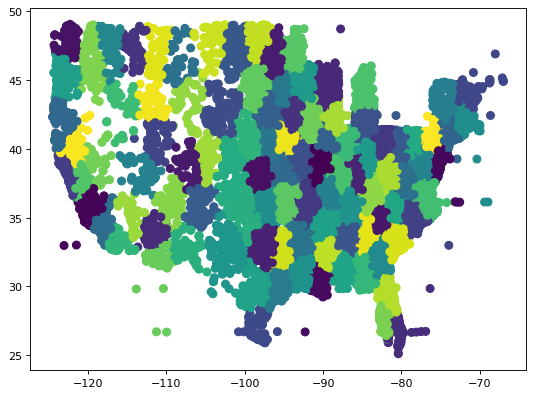

In [13]:
figure(figsize=(8, 6), dpi=80)

plt.scatter(x = x_a['GPS Longitude_x median'] , y = x_a['GPS Lattitude_x median'],
            c=x_a['cluster_label '], s=50, cmap='viridis')

In [14]:
x_a.head()

,AssetID,Asset type,Total Hours mean,Total Hours sum,Total Fuel (Liters) mean,Total Fuel (Liters) sum,Fuel Level (%) mean,Fuel Used Per Hour mean,GPS Lattitude_x median,GPS Longitude_x median,GPS Lattitude_y median,GPS Longitude_y median,cluster_label
0,1022011,Motor Grader,11.946274,4360.39,616.889178,225164.55,49.189890,124.842054,37.505566,-79.872209,37.505566,-79.872209,36
1,1022012,Excavator,12.868740,4697.09,590.211452,215427.18,50.298658,115.823612,36.150522,-106.760364,36.150522,-106.760364,29
2,1022013,Wheel Loader,12.283836,4483.60,603.149479,220149.56,51.511945,124.548055,41.189806,-94.199703,41.189806,-94.199703,96
3,1022014,Off Highway Truck,11.929370,4354.22,613.567808,223952.25,50.527836,112.513837,43.769880,-84.640133,43.769880,-84.640133,71
4,1022015,Off Highway Truck,12.391973,4523.07,577.734822,210873.21,50.880959,135.018639,39.725954,-83.868155,39.725954,-83.868155,54


In [15]:
by_asset_cluster_agg = x_a.groupby(['cluster_label ']).agg({
                                   'Total Hours mean':'mean',
                                   'Fuel Used Per Hour mean': 'mean',
                                   'AssetID ': 'count',
                                   'GPS Longitude_x median':'mean',
                                   'GPS Lattitude_x median':'mean',
                                    })
by_asset_cluster_agg.describe()

,Total Hours mean,Fuel Used Per Hour mean,AssetID,GPS Longitude_x median,GPS Lattitude_x median
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,12.054928,137.744546,195.640000,-95.986212,38.472137
std,0.027409,1.541785,96.001528,13.947998,5.254419
min,11.971549,134.533137,55.000000,-123.360568,26.524474
25%,12.040893,136.742056,131.250000,-107.228092,34.820715
50%,12.054064,137.708792,178.000000,-94.663065,38.669464
75%,12.073828,138.723996,237.500000,-84.774406,42.280684
max,12.126862,142.823003,587.000000,-70.970184,47.831169


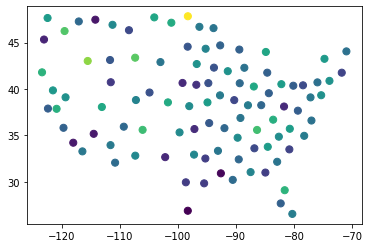

In [16]:
plt.scatter(x = by_asset_cluster_agg['GPS Longitude_x median'] , y = by_asset_cluster_agg['GPS Lattitude_x median'], 
            c = by_asset_cluster_agg['Fuel Used Per Hour mean'], s = 50, cmap='viridis')

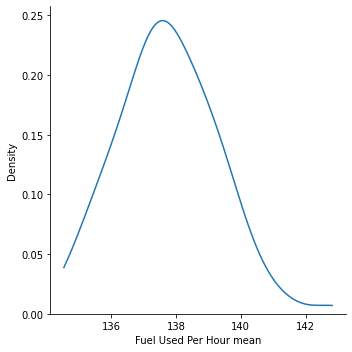

In [17]:
sns.displot(by_asset_cluster_agg, x="Fuel Used Per Hour mean", kind="kde", cut=0)

# time (monthly) based clustering

In [52]:
df_m.head()

,AssetID,Month,Total Hours,Total Fuel (Liters),Fuel Level (%),GPS Lattitude_y,GPS Longitude_y
0,1022011,1,332.26,17195.41,44.737419,37.503592,-79.87343
1,1022011,2,320.62,15486.85,53.417857,37.503592,-79.87343
2,1022011,3,380.47,20758.91,57.904194,37.503592,-79.87343
3,1022011,4,347.52,23425.80,51.499667,37.503592,-79.87343
4,1022011,5,370.30,17106.78,52.237419,37.503592,-79.87343


In [129]:
x_m = gen_clusters(df_m, 200, cols=['AssetID', 'GPS Lattitude_y', 'GPS Longitude_y'])

/Users/eyasuwoldu/opt/anaconda3/envs/hackthis2021/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/eyasuwoldu/opt/anaconda3/envs/hackthis2021/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [130]:
x_m.head()

,index,AssetID,Month,Total Hours,Total Fuel (Liters),Fuel Level (%),Fuel Used Per Hour,GPS Lattitude_y,GPS Longitude_y,cluster_label
0,0,1022011,1,332.26,17195.41,44.737419,101.485699,37.503592,-79.87343,73
1,12,1022011,2,320.62,15486.85,53.417857,114.219444,37.503592,-79.87343,73
2,24,1022011,3,380.47,20758.91,57.904194,130.031358,37.503592,-79.87343,73
3,36,1022011,4,347.52,23425.80,51.499667,155.243641,37.503592,-79.87343,73
4,48,1022011,5,370.30,17106.78,52.237419,278.558056,37.503592,-79.87343,73


No handles with labels found to put in legend.


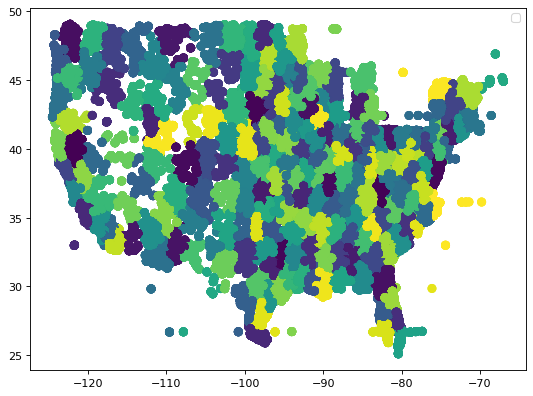

In [132]:
figure(figsize=(8, 6), dpi=80)

plt.scatter(x = x_m['GPS Longitude_y'] , y = x_m['GPS Lattitude_y'],
            c=x_m['cluster_label'], s=50, cmap='viridis')
plt.legend()

In [133]:
by_month_cluster_agg = x_m.groupby(['cluster_label', 'Month',]).agg({
                                   'Total Hours':'mean',
                                   'Fuel Used Per Hour': 'mean',
                                   'AssetID': 'count',
                                   'GPS Longitude_y':'mean',
                                   'GPS Lattitude_y':'mean',
                                    }).reset_index()
by_month_cluster_agg.describe()

,cluster_label,Month,Total Hours,Fuel Used Per Hour,AssetID,GPS Longitude_y,GPS Lattitude_y
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,99.500000,6.500000,735.770339,137.851372,97.415000,-95.031499,38.416501
std,57.746337,3.452772,49.734458,9.268488,49.479242,13.381598,5.227381
min,0.000000,1.000000,561.081333,92.734841,6.000000,-123.909200,26.075236
25%,49.750000,3.750000,705.520363,131.962676,65.000000,-102.927222,34.386397
50%,99.500000,6.500000,734.831356,137.527790,93.000000,-93.975113,38.877235
75%,149.250000,9.250000,766.008449,143.062887,118.250000,-84.772397,42.056977
max,199.000000,12.000000,926.362857,213.981601,349.000000,-68.304798,48.341360


In [134]:
by_month_cluster_agg.head(24)

,cluster_label,Month,Total Hours,Fuel Used Per Hour,AssetID,GPS Longitude_y,GPS Lattitude_y
0,0,1,696.195091,145.270551,110,-121.617319,39.879537
1,0,2,638.792091,136.654636,110,-121.617319,39.879537
2,0,3,690.730636,143.245484,110,-121.617319,39.879537
3,0,4,679.213818,138.159340,110,-121.617319,39.879537
4,0,5,701.149636,139.837518,110,-121.617319,39.879537
5,0,6,678.363273,135.112609,110,-121.617319,39.879537
6,0,7,707.041000,131.887060,110,-121.617319,39.879537
7,0,8,706.530818,139.532733,110,-121.617319,39.879537
8,0,9,677.332909,145.524469,110,-121.617319,39.879537
9,0,10,693.114909,135.117085,110,-121.617319,39.879537


In [136]:
by_month_cluster_agg.to_csv('by_month_cluster_200.csv',index=False)